# i. Problem Understanding

## i.i Business Objective:
- preview of the new destination the user will choose.
- Why?
    - What's the Airbnb's model business?
        - Marktplace (connecting people who have accommodation to people who are looking for accommodation)
        
        - Offer 
            - portfolio size.
            - Diversity/Protfolio density.
            - Average price.

        - Demand
            - Number of users
            - LTV (Lifetime Value)
            - CAC (Client Acquisition Cost)
            - Gross Revenue = (Fee*Numero cliente) - CAC

## i.ii Solution proposal

- Create a model to forecast the first detiny of a new client.
- Make forecasts and load it into a database.
- API
    - Input: user and features.
    - Output: users with their characteristics and their destination prediction

# 0.0 Imports

In [1]:
import joblib
import warnings

import numpy    as np
import pandas   as pd
import seaborn  as sns

import sklearn.metrics      as mtr
import matplotlib.pyplot    as plt

from scipy      import stats
from boruta     import BorutaPy
from xgboost    import XGBClassifier
from lightgbm   import LGBMClassifier

from sklearn.dummy          import DummyClassifier
from sklearn.ensemble       import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LogisticRegression

from sklearn.preprocessing      import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection    import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection  import SelectFromModel

from IPython.display        import Image
from IPython.core.display   import HTML

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [5]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    elif age > 80:
        life_stage = "Late Adulthood"
        
    else:
        life_stage = "Unknown"

    return life_stage

In [6]:
def normal_tests(data):
    
    bx = stats.boxcox(data)[0]
    sq = np.sqrt(data)
    cb = np.cbrt(data)
    log = np.log(data)
    
    return pd.DataFrame({
        'Shapiro': [stats.shapiro(data)[0], stats.shapiro(bx)[0], stats.shapiro(sq)[0], stats.shapiro(cb)[0], stats.shapiro(log)[0]],
        'Skew': [stats.skew(data), stats.skew(bx), stats.skew(sq), stats.skew(cb), stats.skew(log)],
        'Kurtosis': [stats.kurtosis(data), stats.kurtosis(bx), stats.kurtosis(sq), stats.kurtosis(cb), stats.kurtosis(log)]
    }, index=['default', 'boxcox', 'sqrt', 'cuberoot', 'log'])

In [7]:
def ml_scores(model_name, y_true, y_pred, k=10):
    
    accuracy = mtr.balanced_accuracy_score(y_true, y_pred, average='macro')
    precision = mtr.precision_score(y_true, y_pred, average='macro')
    recall = mtr.recall_score(y_true, y_pred, average='macro')
    f1 = mtr.f1_score(y_true, y_pred, average='macro')
    auc = mtr.roc_auc_score(y_true, y_pred, average='macro')
    kappa = mtr.cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({
        'Accuracy': np.round(accuracy, 4),
        'Precision': np.round(precision, 4), 
        'Recall': np.round(recall, 4),
        'F1': np.round(f1, 4),
        'AUC': np.round(auc, 4),
        'Kappa': np.round(kappa, 4)},
        index=[model_name])

## 0.2 Loading Dataset

In [8]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv')

# 1.0 Data Description

In [14]:
df1 = df_raw.copy()

## 1.1 Columns

### 1.1.1 About Columns

- **train_users.csv**

    - id: Id of the line.
    - date_account_created: Date of the creation account.
    - timestamp_first_active: Time  of the first active.
    - date_first_booking: Date of the first booking.
    - gender: Gender of the user.
    - age: Age of the user.
    - singup_method: How the user accessed the account.
    - signup_flow: The page a user came to signup up from
    - language: International language preference
    - affiliate_channel: what kind of paid marketing
    - affiliate_provider: where the marketing is e.g. google, craigslist, other
    - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    - signup_app:
    - first_device_type:
    - first_browser:
    - country_destination: This is the target variable you are to predict


- **sessions.csv - web sessions log for users**
    
    - user_id: to be joined with the column 'id' in users table
    - action
    - action_type
    - action_detail
    - device_type
    - secs_elapsed


- **countries.csv - summary statistics of destination countries in this dataset and their locations**
- **age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination**
- **sample_submission.csv - correct format for submitting your predictions**

### 1.1.2 Rename Columns

It's not need to rename the columns

## 1.2 Data Dimensions

In [15]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 213451
Number of Cols: 16


## 1.3 Data Types

In [16]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.4 Check NA

In [17]:
df1.isna().mean()

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

## 1.5 Fill Out NA

In [18]:
# These clients doesn't made a booking. It will be filled with the date of "today".
df1.loc[df1['date_first_booking'].isna(), 'date_first_booking_is_na'] = 'yes'
df1.loc[df1['date_first_booking_is_na'] != 'sim', 'date_first_booking_is_na'] = 'no'

max_date = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(max_date)

# Age will be filled with median.
df1.loc[df1['age'].isna(), 'age_is_na'] = 'yes'
df1.loc[df1['age_is_na'] != 'sim', 'age_is_na'] = 'no'

age_median = df1['age'].median()
df1['age'] = df1['age'].fillna(age_median)

# It will be filled with a word "unknown".
df1.loc[df1['first_affiliate_tracked'].isna(), 'first_affiliate_tracked_is_na'] = 'yes'
df1.loc[df1['first_affiliate_tracked_is_na'] != 'sim', 'first_affiliate_tracked_is_na'] = 'no'

df1['first_affiliate_tracked'] = df1['first_affiliate_tracked'].fillna('unknown')

## 1.6 Change Data Type

In [19]:
# change to date type
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format='%Y-%m-%d')

# change to date type
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change to date type
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'], format='%Y-%m-%d')

# convert to int
df1['age'] = df1['age'].astype(int)

In [20]:
df1.dtypes

id                                       object
date_account_created             datetime64[ns]
timestamp_first_active           datetime64[ns]
date_first_booking               datetime64[ns]
gender                                   object
age                                       int64
signup_method                            object
signup_flow                               int64
language                                 object
affiliate_channel                        object
affiliate_provider                       object
first_affiliate_tracked                  object
signup_app                               object
first_device_type                        object
first_browser                            object
country_destination                      object
date_first_booking_is_na                 object
age_is_na                                object
first_affiliate_tracked_is_na            object
dtype: object

## 1.7 Descriptive Statistical

In [21]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

### 1.7.1 Numerical Attributes

In [22]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
age,213451.0,43.209444,119.592797,1.0,32.0,34.0,36.0,2014.0,2013,2.767747,16.263619,264.656719
signup_flow,213451.0,3.267387,7.637707,0.0,0.0,0.0,0.0,25.0,25,2.337558,2.234366,3.324444


### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.describe().T

,count,unique,top,freq
id,213451,213451,gxn3p5htnn,1
gender,213451,4,-unknown-,95688
signup_method,213451,3,basic,152897
language,213451,25,en,206314
affiliate_channel,213451,8,direct,137727
affiliate_provider,213451,18,direct,137426
first_affiliate_tracked,213451,8,untracked,109232
signup_app,213451,4,Web,182717
first_device_type,213451,9,Mac Desktop,89600
first_browser,213451,52,Chrome,63845


# 2.0 Feature Engineering

In [46]:
df2 = df1.copy()

## 2.1 Mind Map

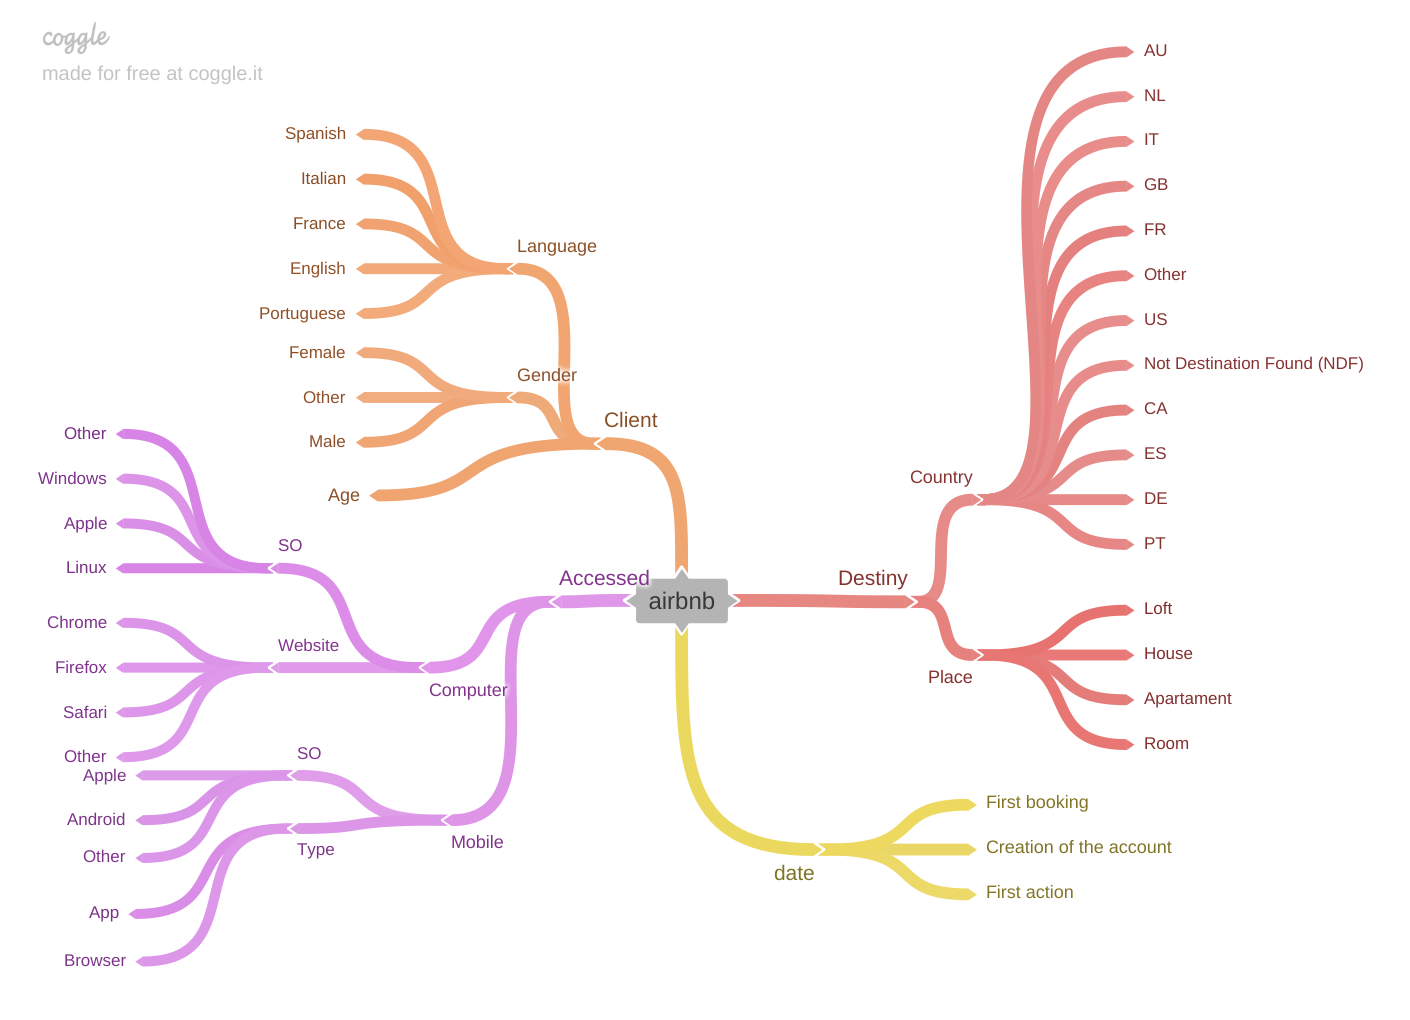

In [47]:
Image('../reports/figures/c1_mind_map.png')

## 2.2 Hypothesis Creation

### 2.2.1 Date

- Most of the appointments took place on the day of account creation.

- 60% or less of the first action occurred on the day of account creation.

- At least 40% of the booking take place during the weekend.

- The number of days since account creation to the first booking is at most 7 days.

### 2.2.2 Client

- At least 60% of customers are at most 40 years old.

- At least 80% of clients use the english language.

- 60% or more of the user are women.

- At most 80% of the user's destination are english-speaking countries.

- Apartments are the types of places most selected by users.

### 2.2.3 Access

- At most 80% of users access by phone.

- The most access acourred by apple's operation systems.

- Linux-based operating systems are the least used.

## 2.3 Final Hypotheses

- Most of the appointments took place on the day of account creation.

- 60% or less of the first action occurred on the day of account creation.

- At least 40% of the first booking take place during the weekend.

- The number of days since account creation to the first booking is at most 7 days.

- At least 60% of customers are at most 40 years old.

- At least 80% of clients use the english language.

- At most 80% of the user's destination are english-speaking countries.

- 60% or more of the user are women.

- At most 80% of users access by phone.

- The most access acourred by apple's operation systems.

## 2.4 Feature Engineering

In [48]:
# Day of week
df2['first_booking_day_of_week'] = df2['date_first_booking'].dt.day_name().tolist()
df2['first_active_account_day_of_week'] = df2['timestamp_first_active'].dt.day_name().tolist()
df2['account_creation_day_of_week'] = df2['date_account_created'].dt.day_name().tolist()

# Day
df2['first_booking_day'] = df2['date_first_booking'].dt.day
df2['first_active_account_day'] = df2['timestamp_first_active'].dt.day
df2['account_creation_day'] = df2['date_account_created'].dt.day

# Month
df2['first_booking_month'] = df2['date_first_booking'].dt.month
df2['first_active_account_month'] = df2['timestamp_first_active'].dt.month
df2['account_creation_month'] = df2['date_account_created'].dt.month

# Year
df2['first_booking_month'] = df2['date_first_booking'].dt.year
df2['first_active_account_month'] = df2['timestamp_first_active'].dt.year
df2['account_creation_month'] = df2['date_account_created'].dt.year

# Days of account creation until the first booking
df2['days_account_creation_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).dt.days

# Days of first active until acount creation
df2['days_first_active_acount_creation'] = (df2['timestamp_first_active'] - df2['date_account_created']).dt.days

# Days of first active until first booking
df2['days_first_active_first_booking'] = (df2['date_first_booking'] - df2['timestamp_first_active']).dt.days

# 3.0 FIltering Variables

In [60]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [61]:
# Filtering the age
df3 = df3.loc[(df3['age'] >= 18) & (df3['age'] <= 90), :]

# The delay of the creation until the booking will need to be positive
df3 = df3.loc[df3['days_account_creation_first_booking'] >=0, :]

## 3.2 Filtering Columns

In [62]:
# Droping the id column
df3.drop(columns=['id', 'date_first_booking', 'timestamp_first_active', 'date_account_created'], axis=1, inplace=True)

# 4.0 Exploratory Data Analysis

In [63]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variables

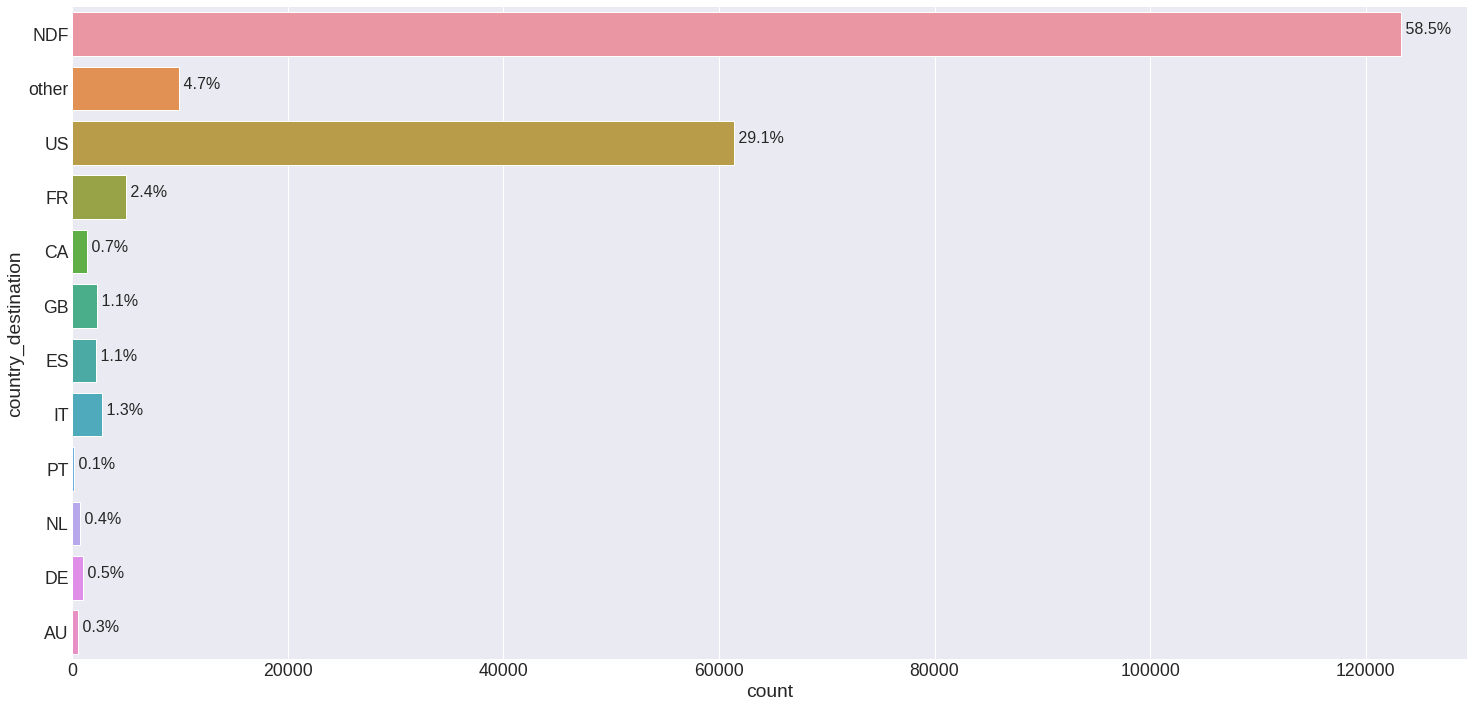

In [64]:
ax = sns.countplot(y='country_destination', data=df4)

total = df4['country_destination'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

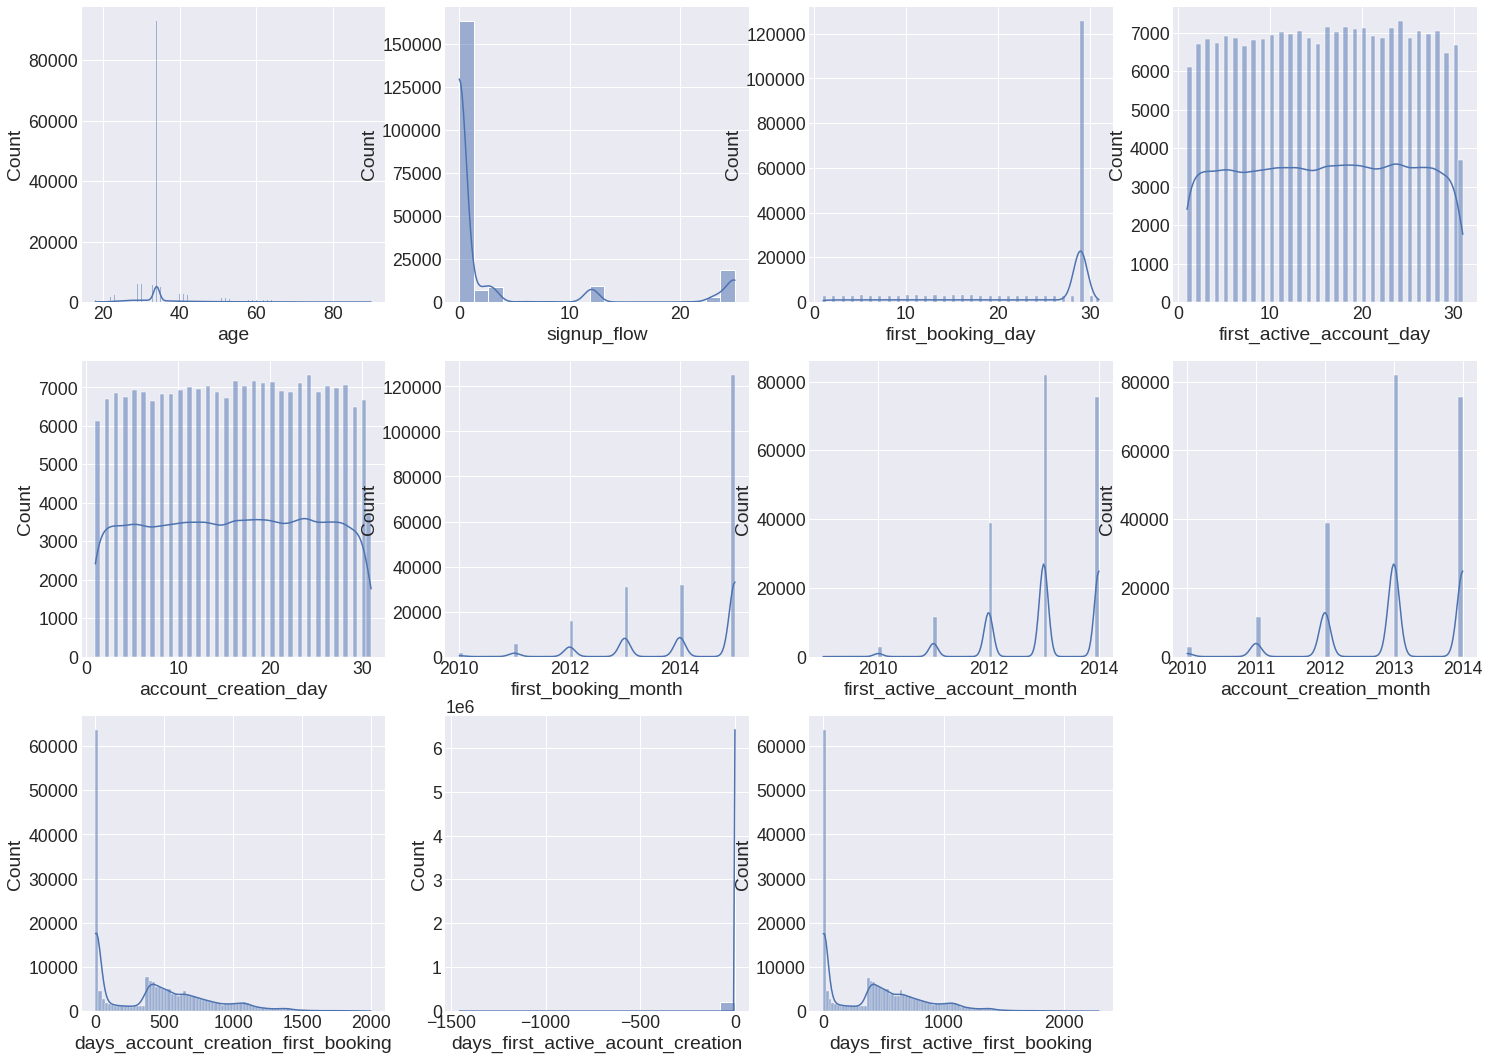

In [65]:
aux1 = df4.select_dtypes(exclude='object')

columns = aux1.columns.tolist()
j = 1

plt.figure(figsize=(25, 25))

for column in columns:
    plt.subplot(4, 4, j)
    sns.histplot(aux1[column], kde=True);

    j += 1

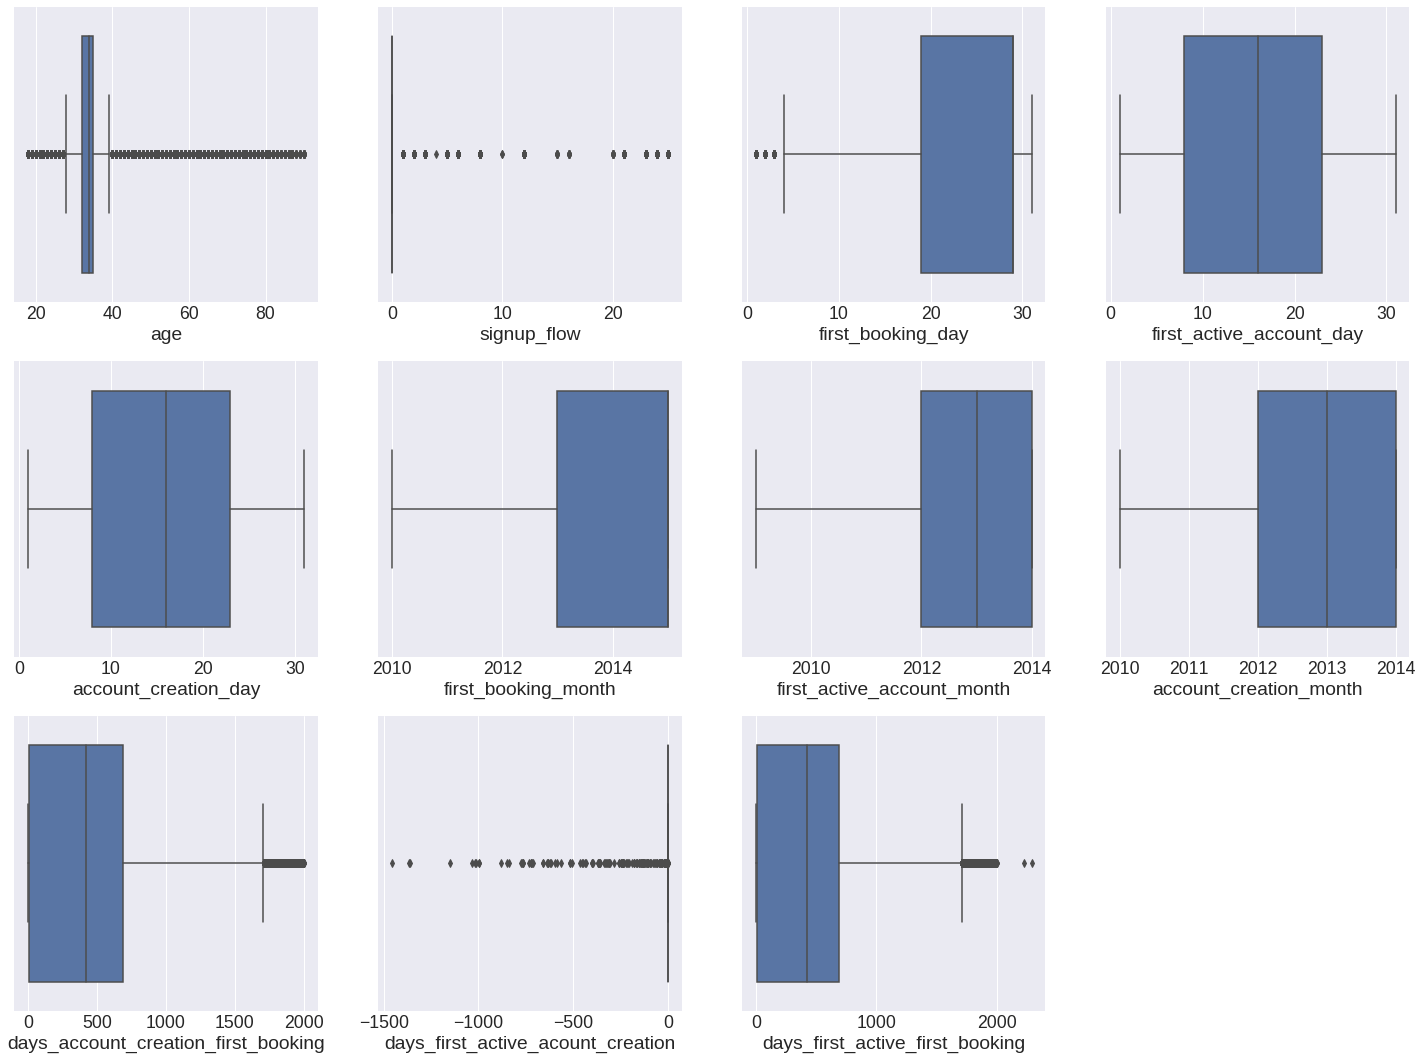

In [66]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.tolist()
j = 1

plt.figure(figsize=(25, 25))

for column in columns:
    plt.subplot(4, 4, j)
    sns.boxplot(aux1[column]);

    j += 1

### 4.1.3 Categorical Variables

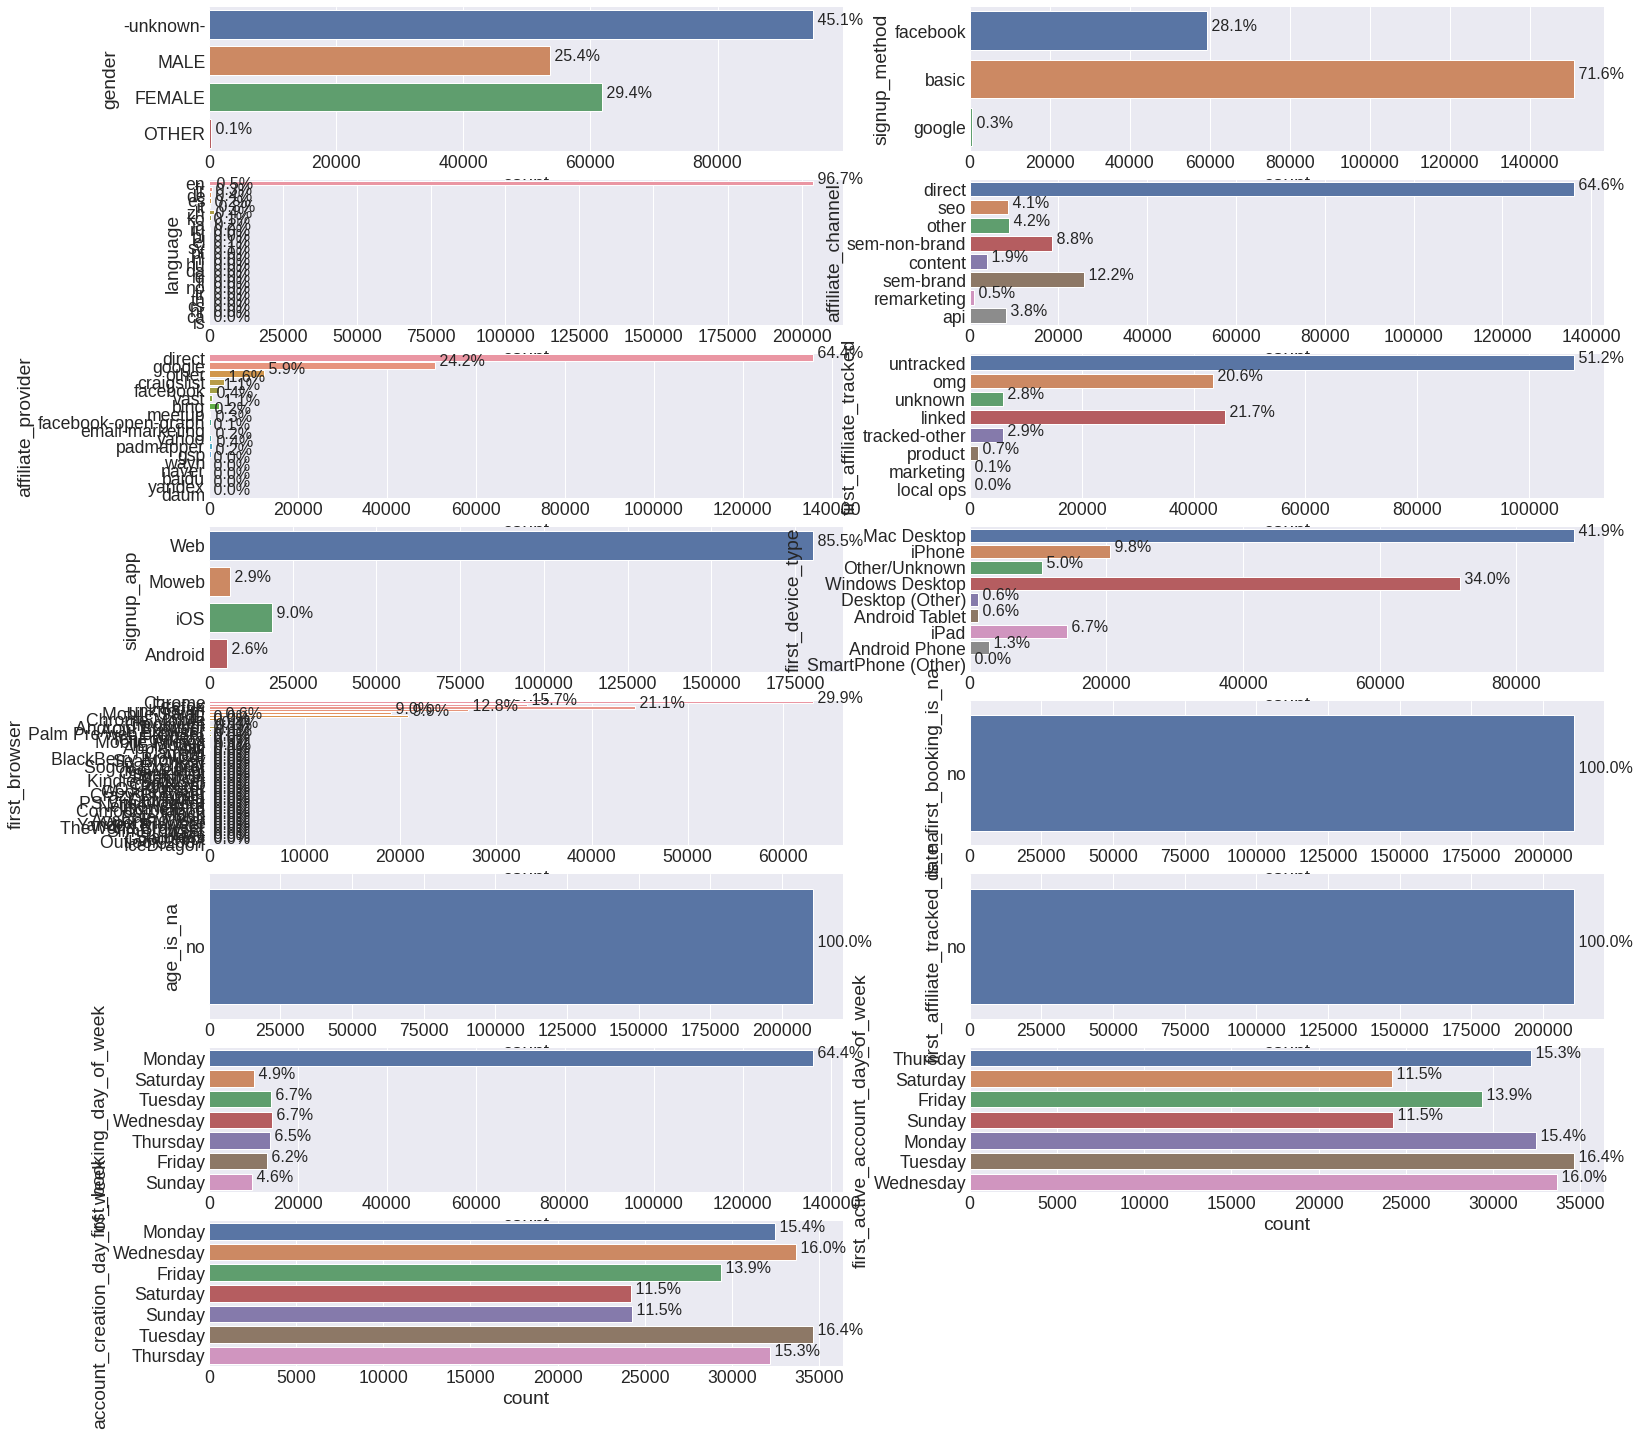

In [67]:
aux1 = df4.drop(columns=['country_destination'], axis=1).select_dtypes(include='object')
columns = aux1.columns.tolist()
j = 1

plt.figure(figsize=(25, 25))

for column in columns:
    plt.subplot(8, 2, j)
    ax = sns.countplot(y=column, data=aux1)
    
    total = aux1[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

## 4.2 Bivariate Analysis

- Most of the appointments took place on the day of account creation.

- 60% or less of the first action occurred on the day of account creation.

- At least 40% of the first booking take place during the weekend.

- The number of days since account creation to the first booking is at most 7 days.

- At least 60% of customers are at most 40 years old.

- At least 80% of clients use the english language.

- At most 80% of the user's destination are english-speaking countries.

- 60% or more of the user are women.

- At most 80% of users access by phone.

- The most access acourred by apple's operation systems.

### H1 80% or more of the first booking occurred at least one day after the creation of the account.

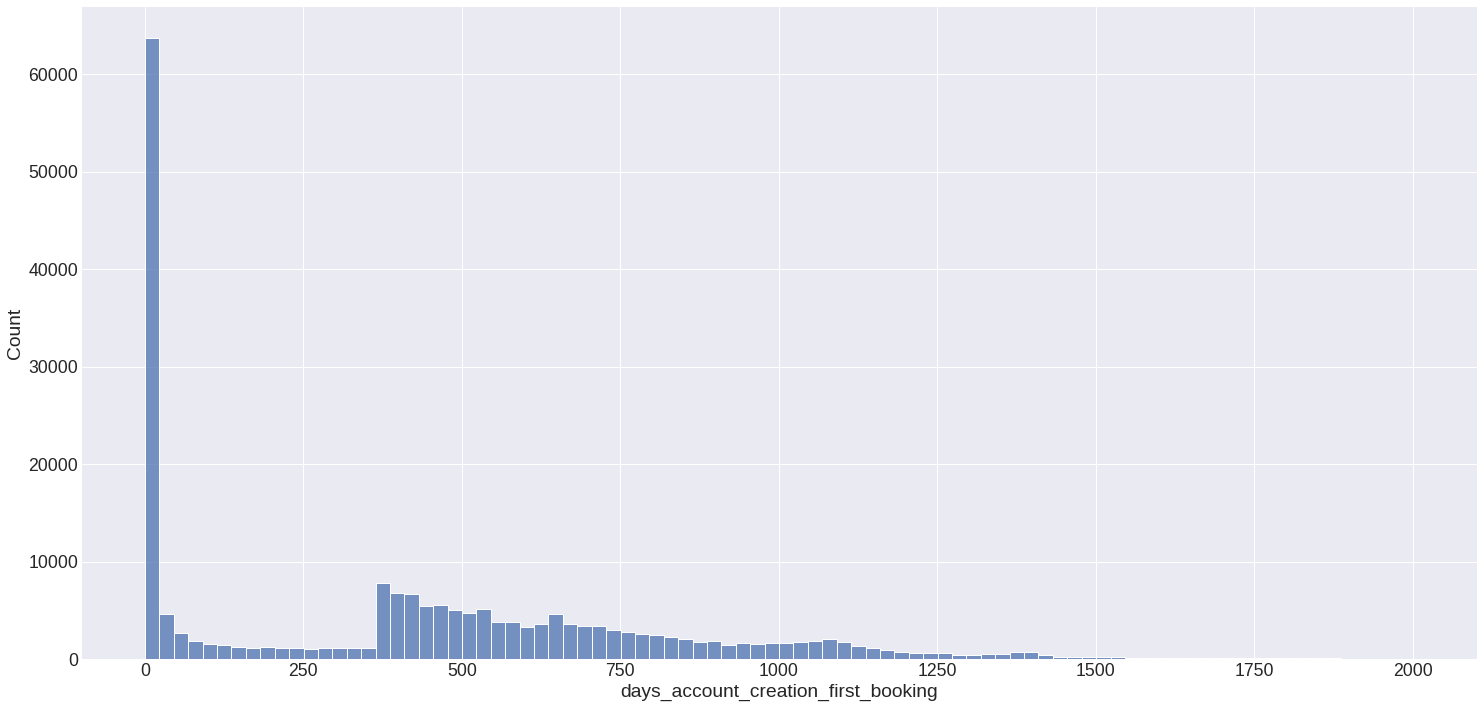

In [70]:
sns.histplot(x='days_account_creation_first_booking', data=df4);

In [59]:
df4['days_account_creation_first_booking'].head()

0    1827
1    1496
2     -57
3     278
4    -208
Name: days_account_creation_first_booking, dtype: int64